In [1]:
!pip install librosa numpy pandas matplotlib tensorflow scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ------------------------------ --------- 0.8/1.0 MB 2.4 MB/s eta 0:00:01
   ------------------------------ --------- 0.8/1.0 MB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 1.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

def extract_features(file_path, max_pad_len=174):
    """Extract MFCC features from audio file"""
    try:
        audio, sr = librosa.load(file_path, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        
        if pad_width < 0:
            mfccs = mfccs[:, :max_pad_len]
        else:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None
        
    return mfccs

def prepare_dataset(data_dir, test_size=0.2, random_state=42):
    """Prepare train and validation sets"""
    features = []
    labels = []
    genres = os.listdir(data_dir)
    genre_to_idx = {genre: i for i, genre in enumerate(genres)}
    
    for genre in genres:
        genre_dir = os.path.join(data_dir, genre)
        for audio_file in os.listdir(genre_dir):
            file_path = os.path.join(genre_dir, audio_file)
            mfccs = extract_features(file_path)
            
            if mfccs is not None:
                features.append(mfccs)
                labels.append(genre_to_idx[genre])
    
    features = np.array(features)
    labels = np.array(labels)
    
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        features, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    
    # Add channel dimension for CNN
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    
    return X_train, X_val, y_train, y_val, genre_to_idx

In [3]:
from tensorflow.keras import layers, models

def build_model(input_shape, num_classes):
    """Build CNN model for genre classification"""
    model = models.Sequential()
    
    # Conv Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    
    # Conv Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    
    # Conv Block 3
    model.add(layers.Conv2D(128, (2, 2), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    
    # Flatten and Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [7]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Parameters
DATA_DIR = 'genres'
EPOCHS = 50
BATCH_SIZE = 32

# Prepare dataset
X_train, X_val, y_train, y_val, genre_map = prepare_dataset(DATA_DIR)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(genre_map))
y_val = to_categorical(y_val, num_classes=len(genre_map))

# Build model
input_shape = X_train.shape[1:]
model = build_model(input_shape, len(genre_map))

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Updated callbacks with .keras extension
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'genre_classifier.keras',  # Changed to .keras
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

# Save genre mapping
np.save('genre_map.npy', genre_map)

Epoch 1/50


C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.2547 - loss: 3.3531 - val_accuracy: 0.1300 - val_loss: 8.6987
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.5118 - loss: 1.3690 - val_accuracy: 0.1850 - val_loss: 3.1647
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.6833 - loss: 0.9459 - val_accuracy: 0.2550 - val_loss: 2.3476
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7504 - loss: 0.6820 - val_accuracy: 0.2750 - val_loss: 2.1067
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.7948 - loss: 0.5861 - val_accuracy: 0.3400 - val_loss: 1.9601
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8477 - loss: 0.4355 - val_accuracy: 0.4150 - val_loss: 1.9634
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9209 - loss: 0.2863 - val_accuracy: 0.5350 - val_loss: 1.4018
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9183 - loss: 0.2518 - val_accuracy: 0.5800 - val_

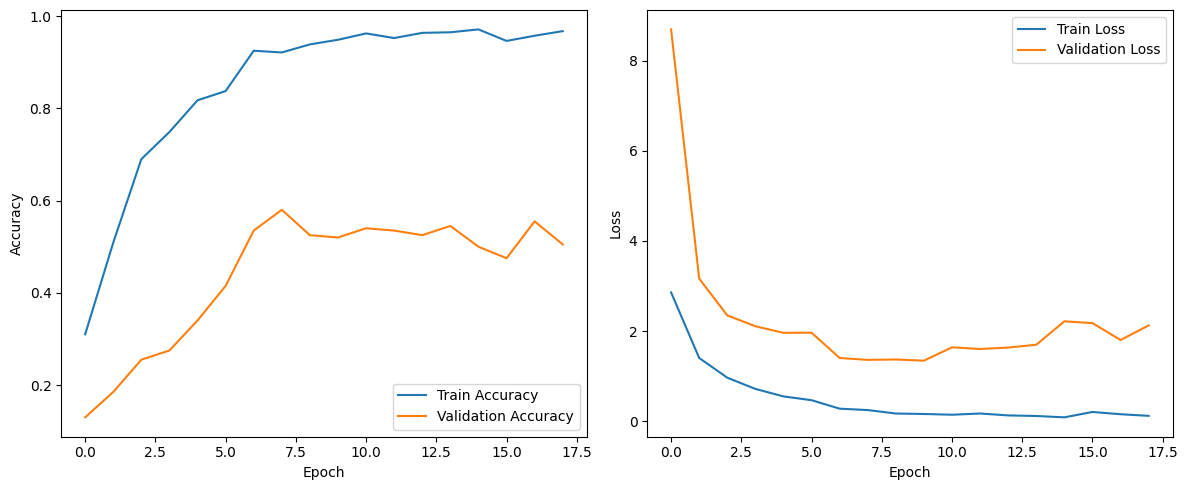

In [8]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
def predict_genre(audio_path, model_path='genre_classifier.keras'):
    """Predict the genre of an audio file"""
    try:
        # 1. Load the trained model
        model = tf.keras.models.load_model(model_path)
        
        # 2. Load genre mapping
        genre_map = np.load('genre_map.npy', allow_pickle=True).item()
        idx_to_genre = {v: k for k, v in genre_map.items()}
        
        # 3. Extract features from audio file
        features = extract_features(audio_path)
        if features is None:
            return {"error": "Could not process audio file"}
            
        # 4. Prepare for prediction (add batch and channel dimensions)
        features = features[np.newaxis, ..., np.newaxis]
        
        # 5. Make prediction
        predictions = model.predict(features)
        predicted_idx = np.argmax(predictions)
        predicted_genre = idx_to_genre[predicted_idx]
        confidence = float(predictions[0][predicted_idx])
        
        return {
            'genre': predicted_genre,
            'confidence': confidence,
            'all_predictions': {idx_to_genre[i]: float(pred) 
                               for i, pred in enumerate(predictions[0])}
        }
        
    except Exception as e:
        return {"error": str(e)}

In [18]:
result = predict_genre('genres/pop/pop.00097.au')

print(f"Predicted genre: {result['genre']} (confidence: {result['confidence']:.2%})")
print("\nAll predictions:")
for genre, prob in result['all_predictions'].items():
    print(f"{genre}: {prob:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Predicted genre: pop (confidence: 100.00%)

All predictions:
blues: 0.00%
classical: 0.00%
country: 0.00%
disco: 0.00%
hiphop: 0.00%
jazz: 0.00%
metal: 0.00%
pop: 100.00%
reggae: 0.00%
rock: 0.00%
